In [1]:
from pathlib import Path
import numpy as np
import SimpleITK as sitk
%matplotlib notebook
import multiscale.ultrasound.reconstruction as recon
import multiscale.itk.itk_plotting as iplt
import multiscale.itk.registration as reg
import multiscale.itk.process as proc
import multiscale.utility_functions as util
import matplotlib.pyplot as plt
import math
import pandas as pd
import tiffile as tif
import pickle
import os

In [2]:
def open_us(us_path, dynamic_range, spacing, origin):
    """Open the US image, window it to a dynamic range, and rotate it to microscope coordinate axes"""
    raw_image = sitk.ReadImage(str(us_path))
    windowed_image = proc.window_image(raw_image, dynamic_range)
    us_image = rotate_axes_to_microscope(windowed_image)
    
    us_image.SetSpacing(spacing)
    us_image.SetOrigin(origin)
    
    return us_image

def rotate_axes_to_microscope(image):
    """Rotate the US axes to be along the microscope axes"""
    arr = sitk.GetArrayFromImage(image)
    arr_rot = np.swapaxes(arr, 0, 1)
    arr_rot = np.flip(arr_rot, 0).astype(np.uint8)
    return sitk.GetImageFromArray(arr_rot)

def positions_from_ometif(file_path):
    """Read a .ome.tif file and grab the image positions as a numpy array"""
    reader = sitk.ImageFileReader()
    reader.SetFileName(str(file_path))
    reader.ReadImageInformation()
    raw_info = reader.GetMetaData('ImageDescription')
    info = tif.xml2dict(raw_info)
    mpm_list = []
    for position in info['OME']['Image']:
        x = position['StageLabel']['X']
        y = position['StageLabel']['Y']
        z = position['Pixels']['Plane'][0]['PositionZ']
        mpm_list.append(np.array([x, y, z]))
    return np.array(mpm_list)

def get_xy_origin(pl_path):
    """Read an ultrasound position list and get the XY origin"""
    raw_pos_list = util.read_json(us_pl_path)
    pos_list = recon.clean_position_text(raw_pos_list)[0]
    xy_origin = np.min(pos_list, 0)
    return xy_origin

# Rotation

In [3]:
# All US images are on the same positions list for X and Y.  Each has a slightly different Z height based on the indicator gauge
us_pl_path = Path(r'C:\Users\mpinkert\Box\Research\LINK\Phantom Trials\2019-05-04\2019-05-04_US - 3X 100YSep.pos')
us_xy_origin = get_xy_origin(us_pl_path)

# These Z heights are recorded from the gauge and are in microns
us_heights = [0, -6, -6, -7, -6]

us_origins = []
for idx in range(5):
    origin = np.array([us_xy_origin[0], us_xy_origin[1], us_heights[idx]])
    us_origins.append(origin)

In [4]:
# The MPM positions 
metadata_dir = Path(r'F:\Research\LINK\Phantom Trials\Fiducial paper analysis\Metadata images')
mpm_origins = []
for idx in range(5):
    img_path = Path(metadata_dir, 'Fiducial acq ' + str(idx+1) + '.ome.tif')
    positions = positions_from_ometif(img_path)
    mpm_origins.append(np.min(positions, 0))

In [5]:
us_spacing = [25, 25, 25]

#In this case, we are using MPM images downsampled by 8x in XY
mpm_spacing = [8.16, 8.16, 25]

dynamic_range = 50

In [6]:
# Specify where the images are.
mpm_dir = Path(r'F:\Research\LINK\Phantom Trials\Fiducial paper analysis\MPM Images\MPM downsampled')
mpm_paths = []

us_dir = Path(r'F:\Research\LINK\Phantom Trials\Fiducial paper analysis\Ultrasound')
us_paths = []

for idx in range(1, 6):
    mpm_paths.append(Path(mpm_dir, 'MPM acq {}_8x.tif'.format(str(idx))))
    us_paths.append(Path(us_dir, 'US Rotation {}.tif'.format(str(idx))))

In [7]:
mpm_images = []
us_images = []

for idx in range(5):
    mpm_images.append(sitk.ReadImage(str(mpm_paths[idx])))
    mpm_images[idx].SetSpacing(mpm_spacing)
    mpm_images[idx].SetOrigin(mpm_origins[idx])
    us_images.append(open_us(us_paths[idx], dynamic_range, us_spacing, us_origins[idx]))

In [34]:
# Acquire points manually for the XY registrations.
points = []

<IPython.core.display.Javascript object>


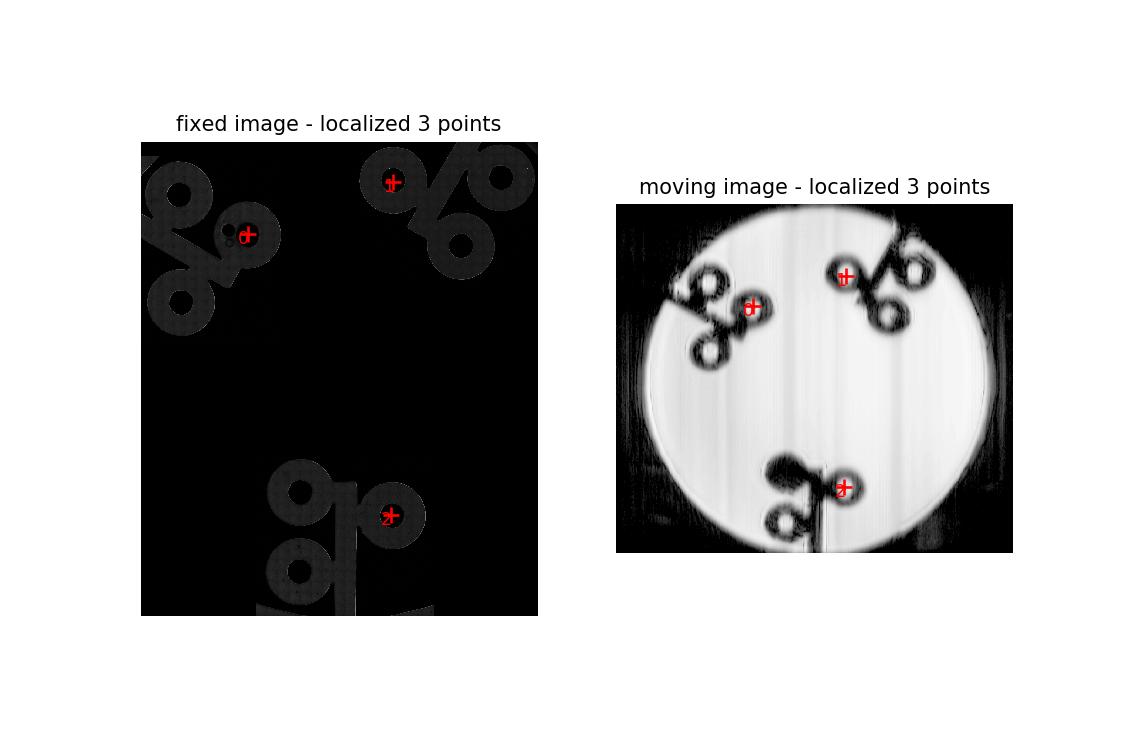

In [35]:
points.append(iplt.RegistrationPointDataAcquisition(mpm_images[0], us_images[0]))

<IPython.core.display.Javascript object>


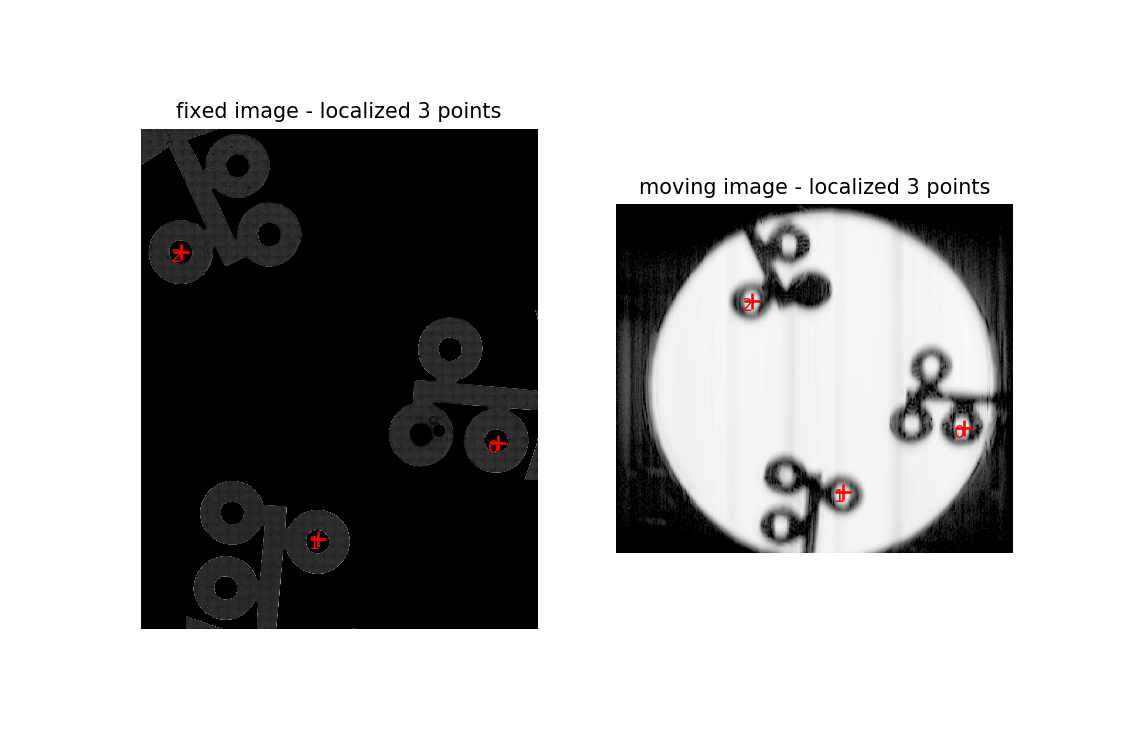

In [36]:
points.append(iplt.RegistrationPointDataAcquisition(mpm_images[1], us_images[1]))

<IPython.core.display.Javascript object>


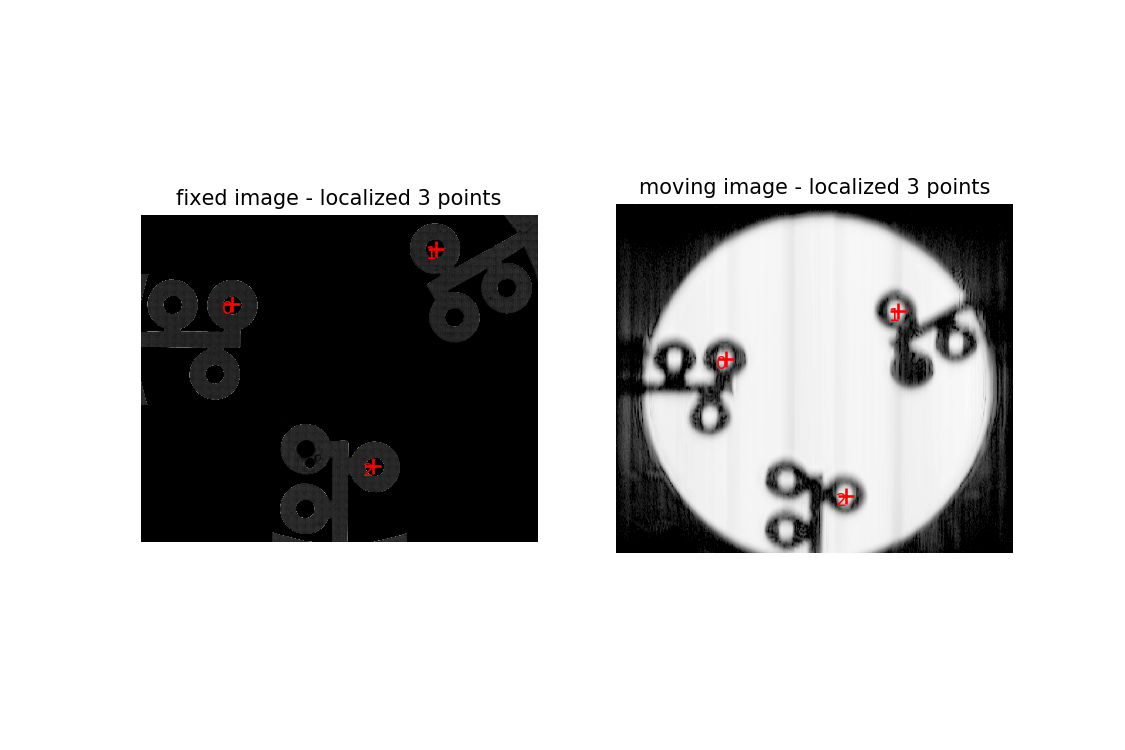

In [37]:
points.append(iplt.RegistrationPointDataAcquisition(mpm_images[2], us_images[2]))

<IPython.core.display.Javascript object>


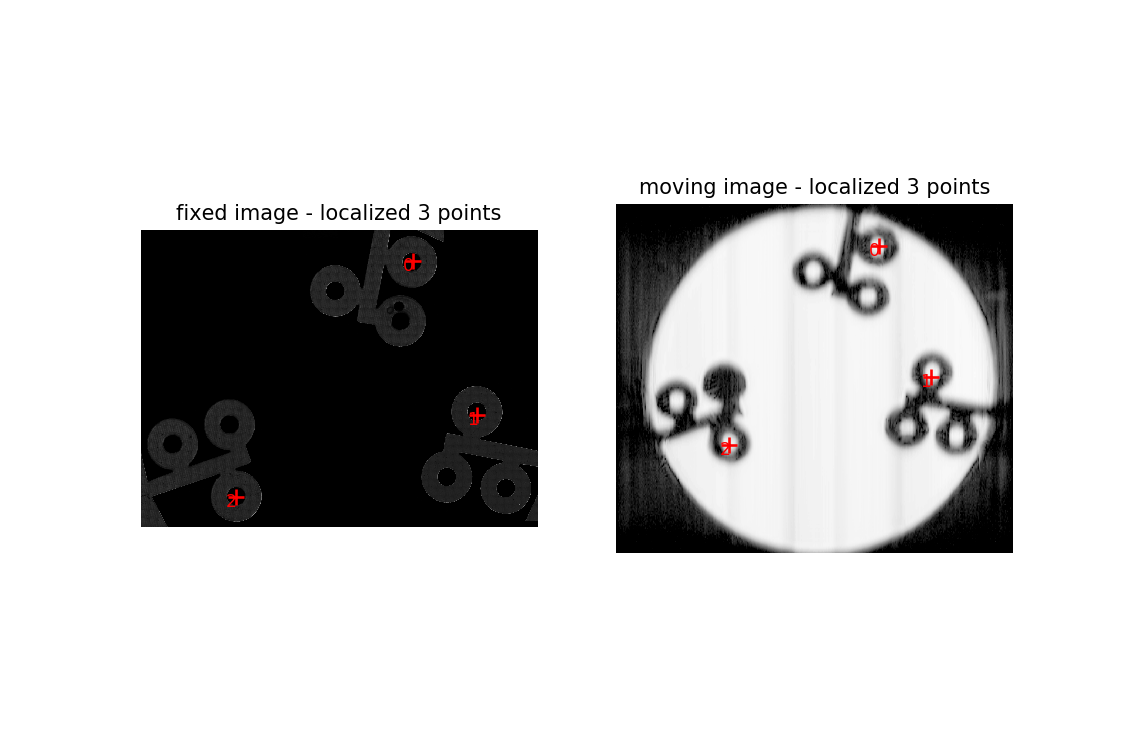

In [38]:
points.append(iplt.RegistrationPointDataAcquisition(mpm_images[3], us_images[3]))

<IPython.core.display.Javascript object>


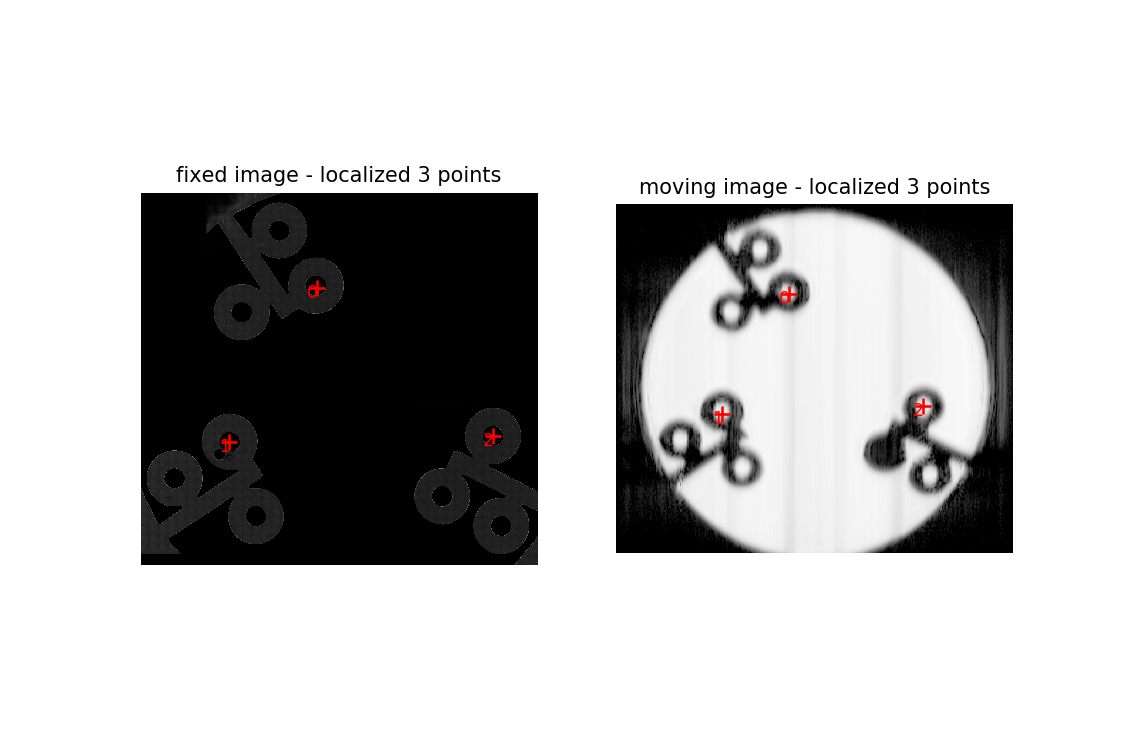

In [39]:
points.append(iplt.RegistrationPointDataAcquisition(mpm_images[4], us_images[4]))

In [40]:
fixed_points = []
moving_points = []
for idx in range(5):
    fixed, moving = points[idx].get_points_flat()
    fixed_points.append(fixed)
    moving_points.append(moving)

In [41]:
fiducial_dir = Path(r'F:\Research\LINK\Phantom Trials\Fiducial paper analysis')
fixed_points_path = Path(fiducial_dir, 'Rotation init points - fixed.txt')
moving_points_path = Path(fiducial_dir, 'Rotation init points - moving.txt')

In [43]:
# Points previously acquired
if len(fixed_points[0]) == 0:
    with open(fixed_points_path, 'rb') as fp:
        fixed_points = pickle.load(fp)   
    with open(moving_points_path, 'rb') as fp:
        moving_points = pickle.load(fp)
else:
    with open(fixed_points_path, 'wb') as fp:
        pickle.dump(fixed_points, fp)
    with open(moving_points_path, 'wb') as fp:
        pickle.dump(moving_points, fp)

In [ ]:
final_params = []
metrics = []
stops = []

In [45]:

for idx in range(5):
    initial_transform = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), fixed_points[idx], moving_points[idx])
    final_transform, metric, stop = reg.register(mpm_images[idx], us_images[idx], initial_transform=initial_transform)
    final_params.append(final_transform.GetParameters())
    metrics.append(metric)
    stops.append(stop)

In [46]:
rotation_params_path = Path(fiducial_dir, 'Rotation final parameters.txt')

if lenfinal_params == 0:
    with open(rotation_params_path, 'rb') as fp:
        pickle.load(fp)
else:
    with open(rotation_params_path, 'wb') as fp:
        pickle.dump(final_params, fp)

In [49]:
mean = np.mean(np.array(final_params), 0)
std = np.std(np.array(final_params), 0)

In [50]:
print(mean)
print(std)

[-8.67074999e-05  2.30036822e-04 -4.55138923e-04  4.57160268e+03
  1.68310347e+03  1.06042156e+03]
[4.15658415e-04 8.98886845e-04 2.95191347e-04 5.45445468e+00
 1.06475244e+01 7.82194560e+01]


In [51]:
registered_images = []
for idx in range(5):
    transform = sitk.VersorRigid3DTransform()
    transform.SetParameters(final_params[idx])
    registered_images.append(sitk.Resample(us_images[idx], mpm_images[idx], transform, sitk.sitkLinear, 0.0, mpm_images[idx].GetPixelID()))

<IPython.core.display.Javascript object>


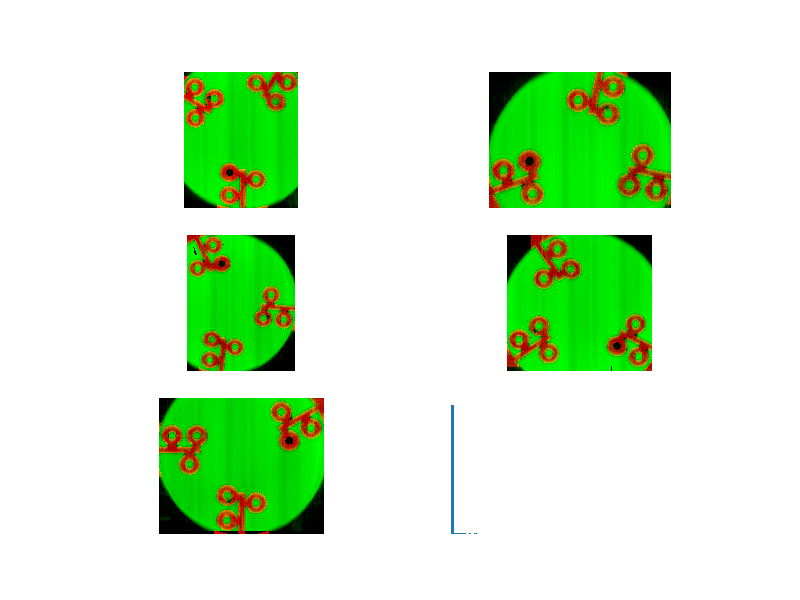

(0.0, 1.0, 0.0, 1.0)

In [52]:
fig, ax = plt.subplots(3, 2)
for idx in range(5):
    if idx == 0:
        slice = 4
    else:
        slice = 1
    overlay = iplt.overlay_images(mpm_images[idx], registered_images[idx], slice=slice)
    ax[int(idx % 3), int(np.floor(idx/3))].imshow(overlay)
    ax[int(idx % 3), int(np.floor(idx/3))].axis('off')
    
ax[2, 1].axis('off')

# Height determination

In [ ]:
def connected_components(us_image):
    """Process the US image using Otsu thresholding and binary opening/closing to get the connected components"""
    thresh_filter = sitk.OtsuThresholdImageFilter()
    thresh_filter.SetInsideValue(0)
    thresh_filter.SetOutsideValue(1)
    thresh_img = thresh_filter.Execute(us_image)
    thresh_value = thresh_filter.GetThreshold()

    print("Threshold used: " + str(thresh_value))

    cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(thresh_img, [6, 6, 3])
    cleaned_thresh_img = sitk.BinaryClosingByReconstruction(cleaned_thresh_img, [6, 6, 3])

    connected_img = sitk.ConnectedComponent(cleaned_thresh_img)
    return connected_img

def get_fiducial_stats(connected_img):
    """Get statistics for each object in a label image"""
    stats = sitk.LabelShapeStatisticsImageFilter()
    stats.ComputeOrientedBoundingBoxOn()
    stats.ComputePerimeterOn()
    stats.Execute(connected_img)    
    return stats

def filter_labels(stats):
    """Filter labels by property so you only get the fiducial circles"""
    return [l for l in stats.GetLabels() if (stats.GetNumberOfPixels(l) < 200000 
                                             and stats.GetEquivalentEllipsoidDiameter(l)[1] > 2000)]

def get_leveled_centroid(stats, true_labels):
    """Get the leveled Z height, equivalent to the bottom of fiducial, for each label"""
    centroid = [stats.GetCentroid(l) for l in true_labels]
    level_center = []
    idx = 0
    for center in centroid:
        level_center.append(center[2] - np.floor((idx+3)/3)*1000)
        idx = idx+1
    return level_center

def get_leveled_top(stats, true_labels):
    """Get the indexes of the top of the bounding box, leveled to be equivalent to the bottom of the fiducial"""
    boxes = [stats.GetBoundingBox(l) for l in true_labels]
    top = []
    for box in boxes:
        top.append(box[2] + box[5])
    level_top = []
    for idx in range(len(top)):
        level_top.append(top[idx] - np.floor((idx+3)/3)*40)

    return level_top

In [8]:
height_image_names = [image for image in os.listdir(us_dir) if (image.startswith('US_H'))]
height_image_names.append('US Rotation 1.tif')
height_z = [-4, -4, -10, -10, -2, -2, 12, 12, 7, 7, 2, 2, 0]
height_images = [open_us(Path(us_dir, height_image_names[idx]), dynamic_range, us_spacing, 
                         np.array([us_xy_origin[0], us_xy_origin[1], height_z[idx]]))
                 for idx in range(len(height_z))]

In [17]:
height_images[0] = open_us(Path(us_dir, height_image_names[0]), dynamic_range, us_spacing, 
                         np.array([us_xy_origin[0], us_xy_origin[1], height_z[0]]))

In [16]:
height_image_names

['US_H-1000_F-7mm.tif',
 'US_H-1000_F-8mm.tif',
 'US_H-2000_F-7mm.tif',
 'US_H-2000_F-9mm.tif',
 'US_H-500_F-7-5mm.tif',
 'US_H-500_F-7mm.tif',
 'US_H1000_F-6mm.tif',
 'US_H1000_F-7mm.tif',
 'US_H2000_F-5mm.tif',
 'US_H2000_F-7mm.tif',
 'US_H500_F-6-5mm.tif',
 'US_H500_F-7mm.tif',
 'US Rotation 1.tif']

In [ ]:
connected_images = [connected_components(image) for image in height_images]

Threshold used: 92.0
Threshold used: 94.0
Threshold used: 86.0
Threshold used: 90.0
Threshold used: 90.0
Threshold used: 92.0
Threshold used: 102.0
Threshold used: 94.0
Threshold used: 96.0


In [ ]:
stats = [get_fiducial_stats(image) for image in connected_images]
true_labels = [filter_labels(stat) for stat in stats]
centroids = [get_leveled_centroid(stats[idx], true_labels[idx]) for idx in range(len(stats))]
tops = [get_leveled_tops(stats[idx], true_labels[idx]) for idx in range(len(stats))]